**1. Connecting Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**2. Imports and Setup**

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import random
from sklearn.metrics import classification_report

# Set random seed for reproducibility
tf.random.set_seed(123)
np.random.seed(123)

# Define dataset paths
train_dir = "/content/drive/MyDrive/3 year/6 semester/Artificial Intelligence & Machine Learning/Week - 5/FruitinAmazon/train"
test_dir = "/content/drive/MyDrive/3 year/6 semester/Artificial Intelligence & Machine Learning/Week - 5/FruitinAmazon/test"

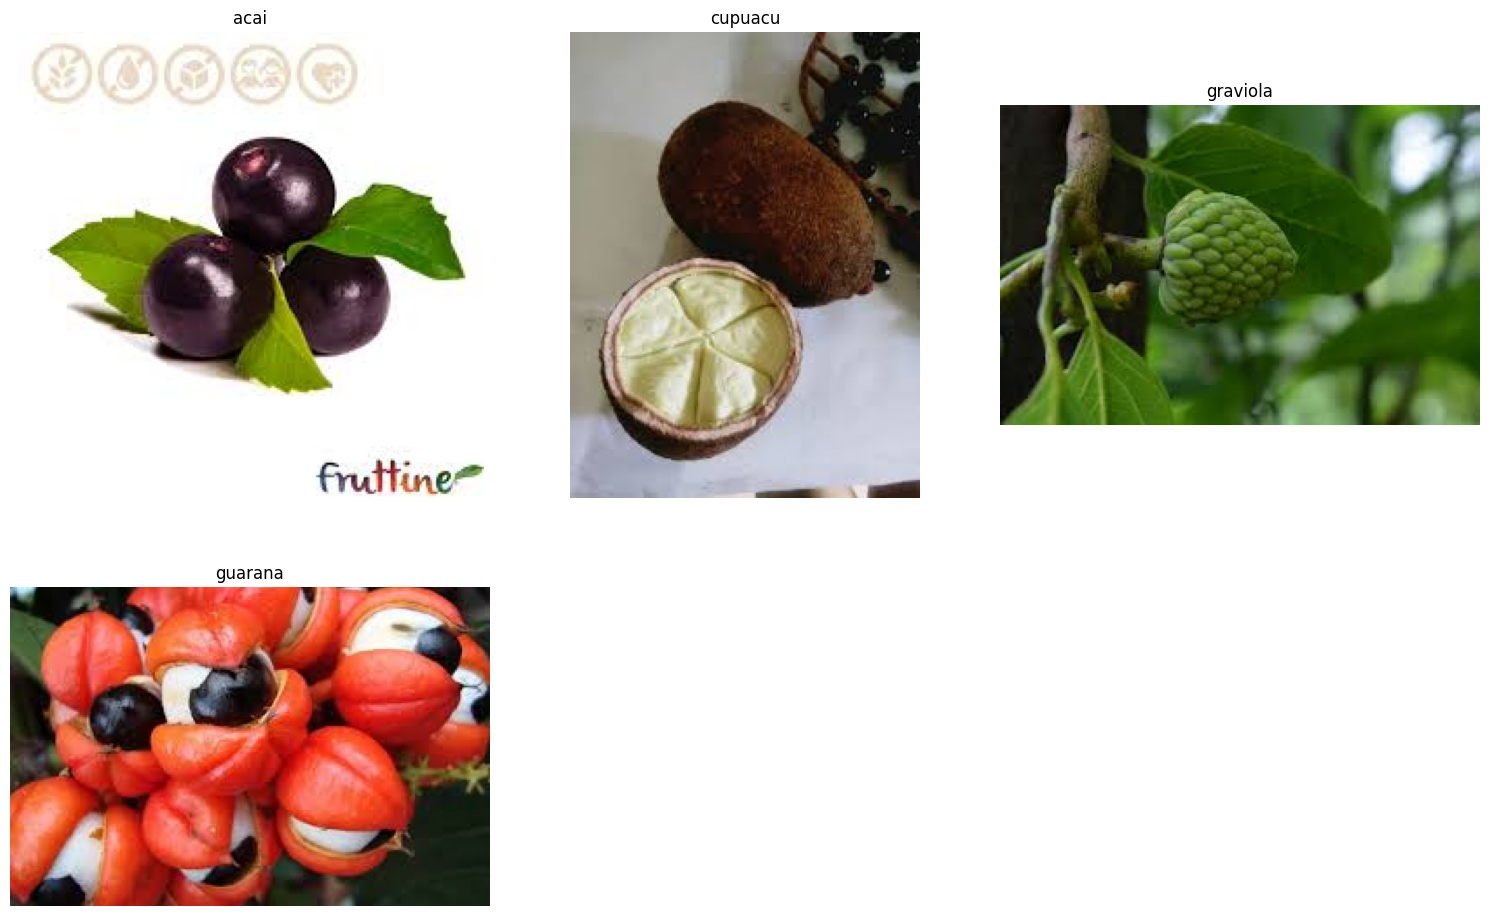

Observation: The dataset contains various fruit images from Amazon, each representing a different class.


In [3]:
# Task 1 - Data Understanding and Visualization
train_dir = "/content/drive/MyDrive/3 year/6 semester/Artificial Intelligence & Machine Learning/Week - 5/FruitinAmazon/train"  # Replace with actual path

# Get class names
class_names = sorted(os.listdir(train_dir))

# Select one random image from each class
images = []
titles = []
for class_name in class_names[:4]:  # Assuming 6 classes as per sample report
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        image_files = os.listdir(class_path)
        if image_files:
            random_image = random.choice(image_files)
            image_path = os.path.join(class_path, random_image)
            images.append(Image.open(image_path))
            titles.append(class_name)

# Display images in 2x3 grid
plt.figure(figsize=(15, 10))
for i in range(len(images)):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i])
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

print("Observation: The dataset contains various fruit images from Amazon, each representing a different class.")

**Task 1 - Data Understanding and Visualization**

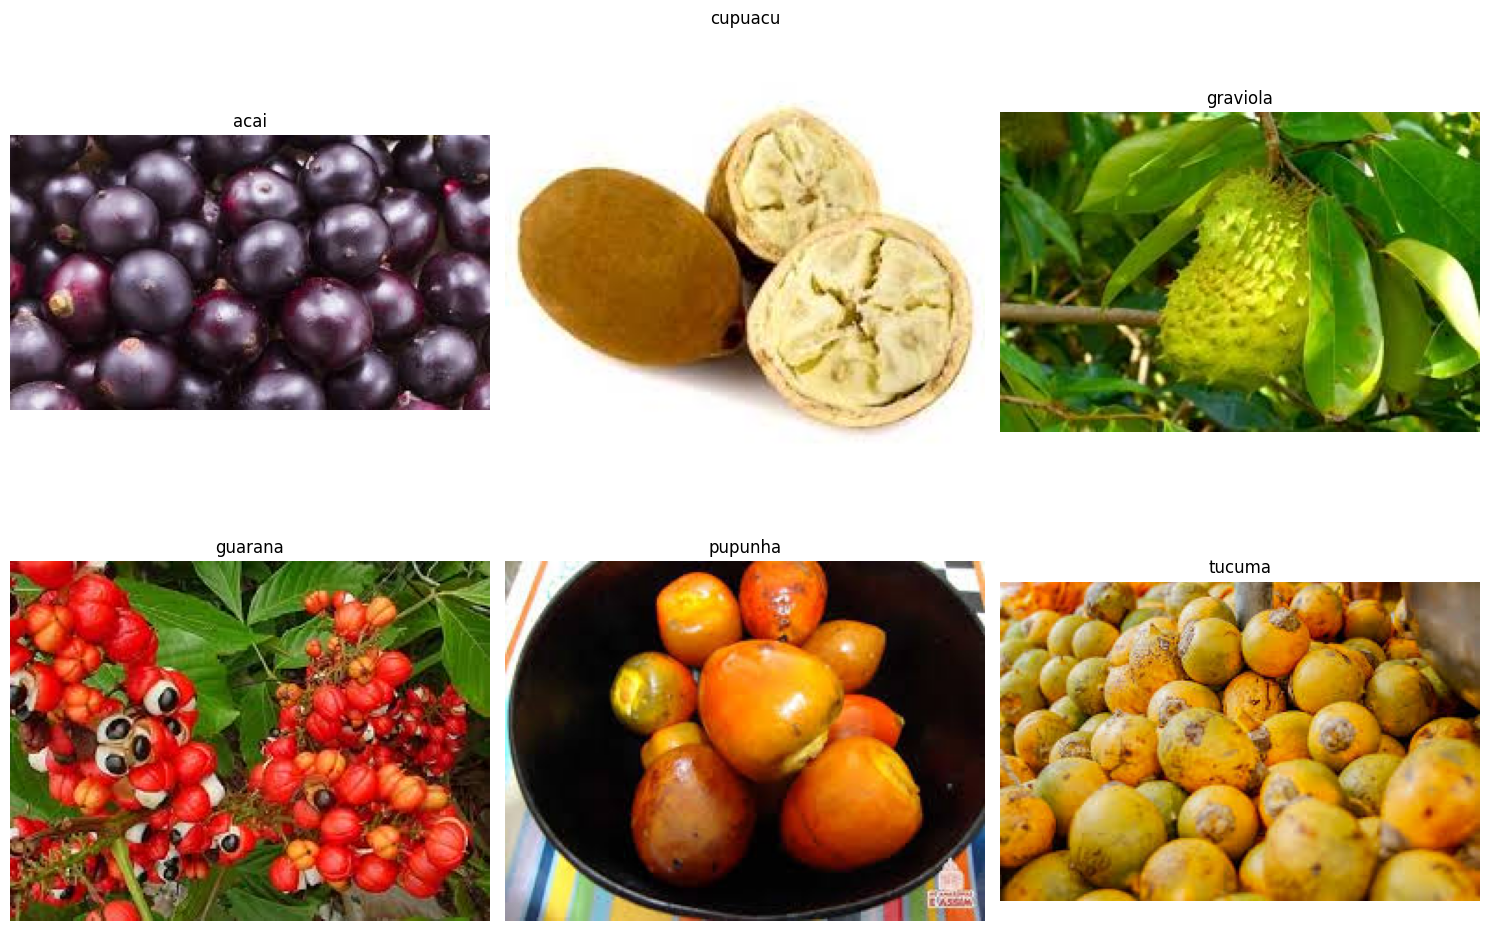

Observation: The dataset contains images of six Amazonian fruits: acai, cupuacu, graviola, guarana, pupunha, and tucuma. Each class appears to have distinct visual characteristics, such as color and shape, which should help the CNN model in classification.


In [4]:
# Get class names
class_names = sorted(os.listdir(train_dir))

# Select one random image from each class
images = []
titles = []
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        image_files = os.listdir(class_path)
        if image_files:
            random_image = random.choice(image_files)
            image_path = os.path.join(class_path, random_image)
            images.append(Image.open(image_path))
            titles.append(class_name)

# Display images in 2x3 grid
plt.figure(figsize=(15, 10))
for i in range(len(images)):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i])
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

print("Observation: The dataset contains images of six Amazonian fruits: acai, cupuacu, graviola, guarana, pupunha, and tucuma. Each class appears to have distinct visual characteristics, such as color and shape, which should help the CNN model in classification.")

**Check for Corrupted Images**

In [5]:
def check_corrupted_images(directory):
    corrupted_images = []

    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            for image_file in os.listdir(class_path):
                image_path = os.path.join(class_path, image_file)
                try:
                    img = Image.open(image_path)
                    img.verify()  # Verify image integrity
                except (IOError, SyntaxError) as e:
                    corrupted_images.append(image_path)
                    print(f"Removed corrupted image: {image_path}")

    if not corrupted_images:
        print("No corrupted images found.")
    return corrupted_images

corrupted = check_corrupted_images(train_dir)

No corrupted images found.


**Task 2 - Loading and Preprocessing Data**

In [6]:
img_height = 128
img_width = 128
batch_size = 16
validation_split = 0.2

# Create preprocessing layer
rescale = tf.keras.layers.Rescaling(1./255)

# Load training dataset
train_ds_raw = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
    validation_split=validation_split,
    subset='training',
    seed=123
)

# Load validation dataset
val_ds_raw = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False,
    validation_split=validation_split,
    subset='validation',
    seed=123
)

# Load test dataset
test_ds_raw = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False
)

# Get number of classes and class names before applying map
num_classes = len(train_ds_raw.class_names)
class_names = train_ds_raw.class_names
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

# Apply normalization
train_ds = train_ds_raw.map(lambda x, y: (rescale(x), y))
val_ds = val_ds_raw.map(lambda x, y: (rescale(x), y))
test_ds = test_ds_raw.map(lambda x, y: (rescale(x), y))

Found 90 files belonging to 6 classes.
Using 72 files for training.
Found 90 files belonging to 6 classes.
Using 18 files for validation.
Found 30 files belonging to 6 classes.
Number of classes: 6
Class names: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']


**Task 3 - Implement CNN Model**

In [7]:
model = keras.Sequential([
    # Convolutional Layer 1
    layers.Conv2D(32, (3, 3), padding='same', strides=1, activation='relu',
                 input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2, 2), strides=2),

    # Convolutional Layer 2
    layers.Conv2D(32, (3, 3), padding='same', strides=1, activation='relu'),
    layers.MaxPooling2D((2, 2), strides=2),

    # Fully Connected Layers
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

# Display model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       2,097,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,116,454 (8.07 MB)

 Trainable params: 2,116,454 (8.07 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

**Task 4 - Train Model**

In [14]:
# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint(
        'best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True
    )
]

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    batch_size=20,
    callbacks=callbacks
)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.8778 - loss: 0.3505

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 303ms/step - accuracy: 0.8727 - loss: 0.3584 - val_accuracy: 0.8889 - val_loss: 0.7039
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 480ms/step - accuracy: 0.8811 - loss: 0.3773 - val_accuracy: 0.8889 - val_loss: 0.3736
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 417ms/step - accuracy: 0.9711 - loss: 0.1818 - val_accuracy: 0.7778 - val_loss: 0.8011
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 275ms/step - accuracy: 1.0000 - loss: 0.1135 - val_accuracy: 0.8333 - val_loss: 0.4235
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 320ms/step - accuracy: 1.0000 - loss: 0.0484 - val_accuracy: 0.8333 - val_loss: 0.3130
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 309ms/step - accuracy: 1.0000 - loss: 0.0161 - val_accuracy: 0.8889 - val_loss: 0.4506
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 273ms/step - accuracy: 1.0000 - loss: 0.0059 - val_accuracy: 0.8333 - val_loss: 0.6294
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 277ms/step - accuracy: 1.0000 - loss: 0.0040 - val_accuracy: 0.8333 - val_loss: 0.8381
Epo

**Task 5 - Evaluate Model**

In [10]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.4792 - loss: 1.5596
Test accuracy: 0.5000
Test loss: 1.4485


**Task 6 - Save and Load Model**

In [11]:
# Save the model
model.save('final_model.h5')

# Load the model
loaded_model = keras.models.load_model('final_model.h5')

# Re-evaluate loaded model
loaded_test_loss, loaded_test_acc = loaded_model.evaluate(test_ds)
print(f"Loaded model test accuracy: {loaded_test_acc:.4f}")
print(f"Loaded model test loss: {loaded_test_loss:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.4792 - loss: 1.5596
Loaded model test accuracy: 0.5000
Loaded model test loss: 1.4485


**Task 7 - Predictions, Classification Report, and Visualization**

In [12]:
# Get predictions for the entire test set
all_predictions = []
all_labels = []

for images, labels in test_ds:
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    all_predictions.extend(predicted_labels)
    all_labels.extend(labels.numpy())

# Generate classification report
print("Classification Report:")
print(classification_report(all_labels, all_predictions,
                          target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
Classification Report:
              precision    recall  f1-score   support

        acai       0.36      1.00      0.53         5
     cupuacu       0.00      0.00      0.00         5
    graviola       1.00      0.20      0.33         5
     guarana       0.50      0.80      0.62         5
     pupunha       0.75      0.60      0.67         5
      tucuma       0.67      0.40      0.50         5

    accuracy                           0.50        30
   macro avg       0.55      0.50      0.44        30
weighted avg       0.55      0.50      0.44        30



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**Visualization of Training Metrics**

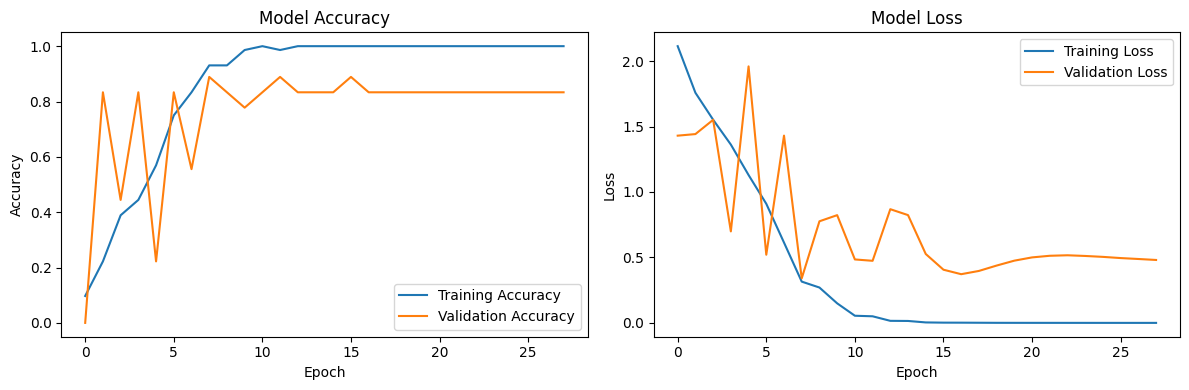

In [13]:
# Plot training history
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()